<a href="https://colab.research.google.com/github/Dasx22/Suicidal-Tweet-Detection/blob/main/Suicide_Tweet_Detection_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow_text

In [ ]:
import tensorflow_text as text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
import pandas as pd
import numpy as np

# Dataset

In [ ]:
df = pd.read_csv('/content/Suicide_Ideation_Dataset(Twitter-based).csv')
df

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post
1783,Starting my day out with a positive attitude! ...,Not Suicide post
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post
1785,2 drunken besties stumble into my room and we ...,Not Suicide post


# Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.Suicide = le.fit_transform(df.Suicide)
df.head()

,Tweet,Suicide
0,making some lunch,0
1,@Alexia You want his money.,0
2,@dizzyhrvy that crap took me forever to put to...,1
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,0
4,Trying out &quot;Delicious Library 2&quot; wit...,0


In [ ]:
df.Suicide.value_counts()

0    1127
1     660
Name: Suicide, dtype: int64

In [ ]:
df = df.dropna()
x = df.drop('Suicide', axis = 'columns')
y = df.Suicide
x, y

(                                                  Tweet
 0                                     making some lunch
 1                           @Alexia You want his money.
 2     @dizzyhrvy that crap took me forever to put to...
 3     @jnaylor #kiwitweets Hey Jer! Since when did y...
 4     Trying out &quot;Delicious Library 2&quot; wit...
 ...                                                 ...
 1782    i have forgotten how much i love my Nokia N95-1
 1783  Starting my day out with a positive attitude! ...
 1784  @belledame222 Hey, it's 5 am...give a girl som...
 1785  2 drunken besties stumble into my room and we ...
 1786  @dancingbonita &quot;I friggin love you!!!&quo...
 
 [1785 rows x 1 columns],
 0       0
 1       0
 2       1
 3       0
 4       0
        ..
 1782    0
 1783    0
 1784    0
 1785    0
 1786    0
 Name: Suicide, Length: 1785, dtype: int64)

In [ ]:
df_Suicide = df[df.Suicide == 1]
df_Ns = df[df.Suicide == 0]

(df_Suicide.shape, df_Ns.shape)

((659, 2), (1126, 2))

# Oversampling - Handling imbalances

In [ ]:
df_Suicide_over = df_Suicide.sample(n = len(df_Ns), replace = True)
(df_Suicide_over.shape, df_Ns.shape)

((1126, 2), (1126, 2))

In [ ]:
df_balanced = pd.concat([df_Ns, df_Suicide_over], axis = 0)
df_balanced.Suicide.value_counts()

0    1126
1    1126
Name: Suicide, dtype: int64

In [ ]:
df_balanced

,Tweet,Suicide
0,making some lunch,0
1,@Alexia You want his money.,0
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,0
4,Trying out &quot;Delicious Library 2&quot; wit...,0
5,"@ValenValdez Oh, that's good to hear. But is i...",0
...,...,...
603,you guys are mean I would never wake up my fri...,1
158,everything that youâve ever dreamed of,1
1029,@joyreaper @WolfensPride @BreitbartNews No dou...,1
1466,why am i so weak that i cant keep up besides i...,1


In [ ]:
x_balanced = df_balanced.drop('Suicide', axis = 'columns')
y_balanced = df_balanced.Suicide

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size = 0.2, stratify = y_balanced)

# Importing BERT model

In [ ]:
bert_preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4")


# Model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  preprocessing_layer = hub.KerasLayer(bert_preprocessor, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [ ]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    ]

classifier_model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = Metrics)

In [ ]:
classifier_model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
57/57 [==============================] - 26s 310ms/step - loss: 0.6599 - accuracy: 0.6108 - precision: 0.6131 - recall: 0.6016
Epoch 2/10
57/57 [==============================] - 18s 319ms/step - loss: 0.6072 - accuracy: 0.6874 - precision: 0.6890 - recall: 0.6837
Epoch 3/10
57/57 [==============================] - 19s 325ms/step - loss: 0.5729 - accuracy: 0.7157 - precision: 0.7168 - recall: 0.7137
Epoch 4/10
57/57 [==============================] - 19s 333ms/step - loss: 0.5372 - accuracy: 0.7701 - precision: 0.7667 - recall: 0.7769
Epoch 5/10
57/57 [==============================] - 19s 333ms/step - loss: 0.5132 - accuracy: 0.7840 - precision: 0.7936 - recall: 0.7680
Epoch 6/10
57/57 [==============================] - 19s 339ms/step - loss: 0.4812 - accuracy: 0.8262 - precision: 0.8349 - recall: 0.8135
Epoch 7/10
57/57 [==============================] - 20s 348ms/step - loss: 0.4725 - accuracy: 0.8151 - precision: 0.8135 - recall: 0.8180
Epoch 8/10
57/57 [================

In [ ]:
classifier_model.evaluate(x_test, y_test)

15/15 [==============================] - 6s 314ms/step - loss: 0.3746 - accuracy: 0.8891 - precision: 0.9147 - recall: 0.8578


[0.37462881207466125,
 0.8891352415084839,
 0.9146919250488281,
 0.8577777743339539]

In [ ]:
y_predicted = classifier_model.predict(x_test)
y_predicted = y_predicted.flatten()

15/15 [==============================] - 6s 345ms/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[208,  18],
       [ 32, 193]])

Text(50.722222222222214, 0.5, 'Truth')

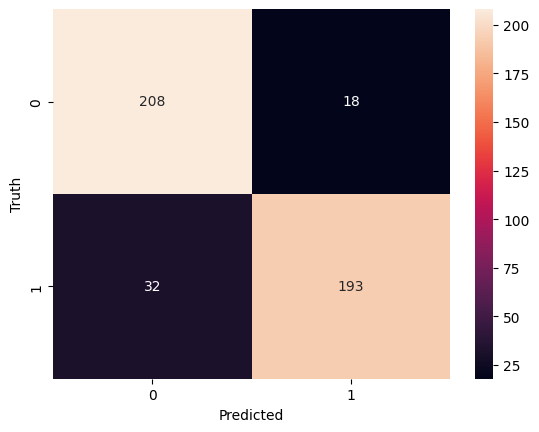

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.87      0.92      0.89       226
           1       0.91      0.86      0.89       225

    accuracy                           0.89       451
   macro avg       0.89      0.89      0.89       451
weighted avg       0.89      0.89      0.89       451

